## Installation

All file changes made by this notebook are temporary. 
You can try to mount your own google drive to store files if you want.


*Kết nối với bộ nhớ drive*

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


*Download thư viện cơ bản*

In [8]:
!pip install insightface==0.2.1 onnxruntime moviepy
!pip install googledrivedownloader
!pip install imageio==2.4.1

     |████████████████████████████████| 4.9 MB 15.1 MB/s 
     |████████████████████████████████| 12.7 MB 37.8 MB/s 


*Clone link git*

In [ ]:
!git clone https://github.com/neuralchen/SimSwap
!cd SimSwap && git pull

*Di chuyển đến mục SimSwap*

In [5]:
import os
os.chdir("/content/drive/Shareddrives/Bấu bã mùa dịch/Hùng/MyJob/SwapFace/SimSwap")

*Install các checkpoint*

In [ ]:
from google_drive_downloader import GoogleDriveDownloader
!wget -P ./arcface_model https://github.com/neuralchen/SimSwap/releases/download/1.0/arcface_checkpoint.tar
!wget https://github.com/neuralchen/SimSwap/releases/download/1.0/checkpoints.zip
!unzip ./checkpoints.zip  -d ./checkpoints
!wget -P ./parsing_model/checkpoint https://github.com/neuralchen/SimSwap/releases/download/1.0/79999_iter.pth

*Install models*

In [ ]:
!wget --no-check-certificate "https://sh23tw.dm.files.1drv.com/y4mmGiIkNVigkSwOKDcV3nwMJulRGhbtHdkheehR5TArc52UjudUYNXAEvKCii2O5LAmzGCGK6IfleocxuDeoKxDZkNzDRSt4ZUlEt8GlSOpCXAFEkBwaZimtWGDRbpIGpb_pz9Nq5jATBQpezBS6G_UtspWTkgrXHHxhviV2nWy8APPx134zOZrUIbkSF6xnsqzs3uZ_SEX_m9Rey0ykpx9w" -O antelope.zip
!unzip ./antelope.zip -d ./insightface_func/models/


## Inference

Import thêm nếu cần các chức năng khác

In [9]:
import cv2
import torch
import fractions
import numpy as np                                                                                          
from PIL import Image
import torch.nn.functional as F
from torchvision import transforms
from models.models import create_model
from options.test_options import TestOptions
from insightface_func.face_detect_crop_multi import Face_detect_crop
from util.videoswap import video_swap
import test_one_image
import test_wholeimage_swapsingle
from util.add_watermark import watermark_image

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3293184/45929032 bytes (7.2%)6930432/45929032 bytes (15.1%)10592256/45929032 bytes (23.1%)14024704/45929032 bytes (30.5%)17670144/45929032 bytes (38.5%)21282816/45929032 bytes (46.3%)24109056/45929032 bytes (52.5%)27320320/45929032 bytes (59.5%)30900224/45929032 bytes (67.3%)34430976/45929032 bytes (75.0%)37920768/45929032 bytes (82.6%)40853504/45929032 bytes (88.9%)

Chuyển về Tensor để sử dụng Pytorch

In [ ]:
transformer = transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

transformer_Arcface = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

detransformer = transforms.Compose([
        transforms.Normalize([0, 0, 0], [1/0.229, 1/0.224, 1/0.225]),
        transforms.Normalize([-0.485, -0.456, -0.406], [1, 1, 1])
    ])

*Sau khi up ảnh lên thì thực hiện crop khuôn mặt và resize về kích thước (224,224)*

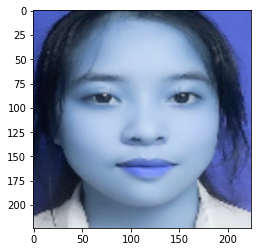

In [21]:
import matplotlib.pyplot as plt
img_name = 'Giang.png'
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
img_path = './crop_224/'
img = cv2.imread(img_path + img_name)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
face = face_cascade.detectMultiScale(img_gray, scaleFactor = 1.5, minNeighbors = 5)
# (x, y, w, h) = face[0,:]
# img_face = img[y: y + h, x: x + w]
# img_face = cv2.resize(img_face, (224,224))
# cv2.imwrite(img_path + "croped_" + img_name, img_face)
# plt.imshow(img_face)
if (x,y,w,h) in face[0,:]: 
    (x, y, w, h) = face[0,:]
    img_face = img[y:y+h, x:x+w]
    img_face = cv2.resize(img_face, (224,224))
    cv2.imwrite(img_path + "croped_" + img_name, img_face)
    plt.imshow(img_face)    
else:
    img_rz = cv2.resize(img, (224,224))
    cv2.imwrite(img_path + "croped_" + img_name, img_rz)
    plt.imshow(img_rz)  

**Thưc hiện swap 2 khuôn mặt với các tham số truyền vào như sau:**
- *pic_a_path: là ảnh muốn kết hợp*
- *pic_b_path: là ảnh muốn nhận kết hợp*
- *output: Sau khi swap xong thì nhận ảnh ở thư mục output/*

In [22]:
!python test_one_image.py --isTrain false --name people --Arc_path arcface_model/arcface_checkpoint.tar --pic_a_path crop_224/Hung_0.jpg --pic_b_path crop_224/croped_Giang.png --output_path output/

------------ Options -------------
Arc_path: arcface_model/arcface_checkpoint.tar
aspect_ratio: 1.0
batchSize: 8
checkpoints_dir: ./checkpoints
cluster_path: features_clustered_010.npy
data_type: 32
dataroot: ./datasets/cityscapes/
display_winsize: 512
engine: None
export_onnx: None
feat_num: 3
fineSize: 512
fp16: False
gpu_ids: [0]
how_many: 50
id_thres: 0.03
image_size: 224
input_nc: 3
instance_feat: False
isTrain: False
label_feat: False
label_nc: 0
latent_size: 512
loadSize: 1024
load_features: False
local_rank: 0
max_dataset_size: inf
model: pix2pixHD
multisepcific_dir: ./demo_file/multispecific
nThreads: 2
n_blocks_global: 6
n_blocks_local: 3
n_clusters: 10
n_downsample_E: 4
n_downsample_global: 3
n_local_enhancers: 1
name: people
nef: 16
netG: global
ngf: 64
niter_fix_global: 0
no_flip: False
no_instance: False
no_simswaplogo: False
norm: batch
norm_G: spectralspadesyncbatch3x3
ntest: inf
onnx: None
output_nc: 3
output_path: output/
phase: test
pic_a_path: crop_224/Hung_0.jpg
pi

# Usage
###### The below example command lines are using mask by default.

### Simple face swapping for already face-aligned images
```
python test_one_image.py --isTrain false --name people --Arc_path arcface_model/arcface_checkpoint.tar --pic_a_path crop_224/6.jpg --pic_b_path crop_224/ds.jpg --output_path output/
```

### Face swapping for video


- Swap only one face within the video(the one with highest confidence by face detection).
```
python test_video_swapsingle.py --isTrain false --use_mask --name people --Arc_path arcface_model/arcface_checkpoint.tar --pic_a_path ./demo_file/Iron_man.jpg --video_path ./demo_file/multi_people_1080p.mp4 --output_path ./output/multi_test_swapsingle.mp4 --temp_path ./temp_results
```
- Swap all faces within the video.
```
python test_video_swapmulti.py --isTrain false --use_mask --name people --Arc_path arcface_model/arcface_checkpoint.tar --pic_a_path ./demo_file/Iron_man.jpg --video_path ./demo_file/multi_people_1080p.mp4 --output_path ./output/multi_test_swapmulti.mp4 --temp_path ./temp_results
```
- Swap the ***specific*** face within the video.
```
python test_video_swapspecific.py --use_mask --pic_specific_path ./demo_file/specific1.png --isTrain false  --name people --Arc_path arcface_model/arcface_checkpoint.tar --pic_a_path ./demo_file/Iron_man.jpg --video_path ./demo_file/multi_people_1080p.mp4 --output_path ./output/multi_test_specific.mp4 --temp_path ./temp_results 
```
When changing the specified face, you need to give a picture of the person whose face is to be changed. Then assign the picture path to the argument "***--pic_specific_path***". This picture should be a front face and show the entire head and neck, which can help accurately change the face (if you still don’t know how to choose the picture, you can refer to the specific*.png of [./demo_file/](https://github.com/neuralchen/SimSwap/tree/main/demo_file)). It would be better if this picture was taken from the video to be changed.

- Swap ***multi specific*** face with **multi specific id** within the video.
```
python test_video_swap_multispecific.py --isTrain false --use_mask  --name people --Arc_path arcface_model/arcface_checkpoint.tar --video_path ./demo_file/multi_people_1080p.mp4 --output_path ./output/multi_test_multispecific.mp4 --temp_path ./temp_results --multisepcific_dir ./demo_file/multispecific
```
The result is that the face corresponding to SRC_01.jpg (png) in the video will be replaced by the face corresponding to DST_01.jpg (png). Then the character corresponding to SRC_02.jpg(png) will be replaced by the face of DST_02.jpg(png), and so on. Note that when using your own data and naming it, do not remove the **0** in SRC_(DST_)**0**1.jpg(png), etc.


### Face swapping for Arbitrary images

- Swap only one face within one image(the one with highest confidence by face detection). The result would be saved to ./output/result_whole_swapsingle.jpg
```
python test_wholeimage_swapsingle.py --isTrain false --use_mask  --name people --Arc_path arcface_model/arcface_checkpoint.tar --pic_a_path ./demo_file/Iron_man.jpg --pic_b_path ./demo_file/multi_people.jpg --output_path ./output/
```
- Swap all faces within one image. The result would be saved to ./output/result_whole_swapmulti.jpg
```
python test_wholeimage_swapmulti.py --isTrain false --use_mask  --name people --Arc_path arcface_model/arcface_checkpoint.tar --pic_a_path ./demo_file/Iron_man.jpg --pic_b_path ./demo_file/multi_people.jpg --output_path ./output/
```
- Swap **specific** face within one image. The result would be saved to ./output/result_whole_swapspecific.jpg
```
python test_wholeimage_swapspecific.py --isTrain false --use_mask  --name people --Arc_path arcface_model/arcface_checkpoint.tar --pic_a_path ./demo_file/Iron_man.jpg --pic_b_path ./demo_file/multi_people.jpg --output_path ./output/ --pic_specific_path ./demo_file/specific2.png
```
- Swap **multi specific** face with **multi specific id** within one image. The result would be saved to ./output/result_whole_swap_multispecific.jpg
```
python test_wholeimage_swap_multispecific.py --isTrain false --use_mask  --name people --Arc_path arcface_model/arcface_checkpoint.tar --pic_b_path ./demo_file/multi_people.jpg --output_path ./output/ --multisepcific_dir ./demo_file/multispecific
```
### About watermark of simswap logo
The above example command lines are to add the simswap logo as the watermark by default. After our discussion, we have added a hyper parameter to control whether to remove watermark.

The usage of removing the watermark is to add an argument: "***--no_simswaplogo***" to the command line, take the command line of "Swap all faces within one image" as an example, the following command line can get the result without watermark:
```
python test_wholeimage_swapmulti.py --no_simswaplogo --isTrain false --use_mask  --name people --Arc_path arcface_model/arcface_checkpoint.tar --pic_a_path ./demo_file/Iron_man.jpg --pic_b_path ./demo_file/multi_people.jpg --output_path ./output/
```
### About using mask for better result
We provide two methods to paste the face back to the original image after changing the face: Using mask or using bounding box. At present, the effect of using mask is the best. All the above code examples are using mask. If you want to use the bounding box, you only need to remove the --use_mask in the code example.
Difference between using mask and not using mask can be found [here](https://imgsli.com/NjE3OTA).
### Parameters
|  Parameters   | Function  |
|  :----  | :----  |
| --name  | The SimSwap training logs name |
| --pic_a_path  | Path of image with the target face |
| --pic_b_path  | Path of image with the source face to swap |
| --pic_specific_path  | Path of image with the specific face to be swapped |
|--multisepcific_dir  |Path of image folder for multi specific face swapping|
| --video_path  | Path of video with the source face to swap |
| --temp_path  | Path to store intermediate files  |
| --output_path  | Path of directory to store the face swapping result  |
| --no_simswaplogo  |The hyper parameter to control whether to remove watermark |
| --use_mask  |The hyper parameter to control whether to use face parsing for the better visual effects(I recommend to use)|


Nếu cần chạy train thêm để tăng chính xác .

In [ ]:
opt = TestOptions()
opt.initialize()
opt.parser.add_argument('-f') ## dummy arg to avoid bug
opt = opt.parse()
opt.pic_a_path = '/content/tinh.jpg' ## or replace it with image from your own google drive
opt.video_path = '/content/nhacrapxin7018406498506247451.mp4' ## or replace it with video from your own google drive
opt.output_path = './output/demo.mp4'
opt.temp_path = './tmp'
opt.Arc_path = './arcface_model/arcface_checkpoint.tar'
opt.isTrain = False
opt.use_mask = True  ## new feature up-to-date

crop_size = 224

torch.nn.Module.dump_patches = True
model = create_model(opt)
model.eval()

app = Face_detect_crop(name='antelope', root='./insightface_func/models')
app.prepare(ctx_id= 0, det_thresh=0.6, det_size=(640,640))

with torch.no_grad():
    pic_a = opt.pic_a_path
    # img_a = Image.open(pic_a).convert('RGB')
    img_a_whole = cv2.imread(pic_a)
    img_a_align_crop, _ = app.get(img_a_whole,crop_size)
    img_a_align_crop_pil = Image.fromarray(cv2.cvtColor(img_a_align_crop[0],cv2.COLOR_BGR2RGB)) 
    img_a = transformer_Arcface(img_a_align_crop_pil)
    img_id = img_a.view(-1, img_a.shape[0], img_a.shape[1], img_a.shape[2])

    # convert numpy to tensor
    img_id = img_id.cuda()

    #create latent id
    img_id_downsample = F.interpolate(img_id, scale_factor=0.5)
    latend_id = model.netArc(img_id_downsample)
    latend_id = latend_id.detach().to('cpu')
    latend_id = latend_id/np.linalg.norm(latend_id,axis=1,keepdims=True)
    latend_id = latend_id.to('cuda')

    video_swap(opt.video_path, latend_id, model, app, opt.output_path,use_mask=opt.use_mask)
    #test_one_image(opt.video_path, latend_id, model, app, opt.output_path, temp_results_dir=opt.temp_path, use_mask=opt.use_mask)

# **Flask**



# **utils**

In [ ]:
import numpy as np
import json
import cv2
import torch
from PIL import Image
import torch.nn.functional as F
from torchvision import transforms
from models.models import create_model
from options.test_options import TestOptions 

def resize_image(img):
    img_rz = img.resize((224,224))
    return img_rz



def _swap_face(pic_a, pic_b):
    transformer = transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    transformer_Arcface = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])  

    detransformer = transforms.Compose([
            transforms.Normalize([0, 0, 0], [1/0.229, 1/0.224, 1/0.225]),
            transforms.Normalize([-0.485, -0.456, -0.406], [1, 1, 1])
        ])
    
    
    opt = TestOptions().parse()

    start_epoch, epoch_iter = 1, 0

    torch.nn.Module.dump_patches = True
    model = create_model(opt)
    model.eval()

    with torch.no_grad():
        
        img_a = Image.open(pic_a).convert('RGB')
        img_a = transformer_Arcface(img_a)
        img_id = img_a.view(-1, img_a.shape[0], img_a.shape[1], img_a.shape[2])


        img_b = Image.open(pic_b).convert('RGB')
        img_b = transformer(img_b)
        img_att = img_b.view(-1, img_b.shape[0], img_b.shape[1], img_b.shape[2])

        # convert numpy to tensor
        img_id = img_id.cuda()
        img_att = img_att.cuda()

        #create latent id
        img_id_downsample = F.interpolate(img_id, scale_factor=0.5)
        latend_id = model.netArc(img_id_downsample)
        latend_id = latend_id.detach().to('cpu')
        latend_id = latend_id/np.linalg.norm(latend_id,axis=1,keepdims=True)
        latend_id = latend_id.to('cuda')


        ############## Forward Pass ######################
        img_fake = model(img_id, img_att, latend_id, latend_id, True)


        for i in range(img_id.shape[0]):
            if i == 0:
                row1 = img_id[i]
                row2 = img_att[i]
                row3 = img_fake[i]
            else:
                row1 = torch.cat([row1, img_id[i]], dim=2)
                row2 = torch.cat([row2, img_att[i]], dim=2)
                row3 = torch.cat([row3, img_fake[i]], dim=2)

        #full = torch.cat([row1, row2, row3], dim=1).detach()
        full = row3.detach()
        full = full.permute(1, 2, 0)
        output = full.to('cpu')
        output = np.array(output)
        output = output[..., ::-1]

        output = output*255
        cv2.imwrite('static/results' + str(pic_a) + '.jpg',output)

class NumpyEncoder(json.JSONEncoder):
    '''
    Encoding numpy into json
    '''
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        if isinstance(obj, np.int32):
            return int(obj)
        if isinstance(obj, np.int64):
            return int(obj)
        if isinstance(obj, np.float32):
            return float(obj)
        if isinstance(obj, np.float64):
            return float(obj)
        return json.JSONEncoder.default(self, obj)

# **server**

In [ ]:
!pip install flask_ngrok

In [ ]:
from flask import Flask, request, render_template
from PIL import Image
import cv2
import io
import torch
import torch.nn.functional as F 
from torchvision import transforms
from models.models import create_model
from options.test_options import TestOptions
import utils
import json
import os

from flask_ngrok import run_with_ngrok

app = Flask(__name__)
# run_with_ngrok(app)

@app.route('/hello')
def _hello():
    return render_template('./index.html')


@app.route("/swapface", methods=['post'])
def swapface():
    data = {"Uploaded files": False}
    if request.files['image'] and request.files['image1']:
        img = request.files['image']
        image = img.read()
        img1 = request.files['image1']
        image1 = img1.read()
        image = Image.open(io.BytesIO(image))
        image1 = Image.open(io.BytesIO(image1))
        
        image = utils.resize_image(image)
        image1 = utils.resize_image(image1)
        
        img.save(os.path.join(app.root_path, 'static/uploads/', img.filename))
        img1.save(os.path.join(app.root_path, 'static/uploads/', img1.filename))
        # _swap_face(image, image1)
        data['Uploaded files'] = True
    return json.dumps(data, ensure_ascii=False, cls=utils.NumpyEncoder)

app.run(host='127.0.0.1')

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
